# Prepocesamiento

In [64]:
# Install requirements
# !pip3 install -r requirements.txt > dataset/Logs

In [65]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder,scale
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="Your_Name")
N_DATASET=1
COLAB = 0 # COLAB =1 si usamos colab

DATASETS = ["homosexualf.csv", "homosexualh.csv", "heterosexual.csv"]

In [66]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path_actual = "/content/drive/My Drive/NoSupervisado/"
    dataset = path_actual + DATASETS[N_DATASET]

else:
    path_actual =     os.getcwd()
    print("Path actual: ",path_actual)
    dataset = path_actual + "/dataset/"+ DATASETS[N_DATASET]
    print("Dataset path: ", dataset)

Path actual:  /home/iciac/Escritorio/CursoIA/AprendizajeNoSupervisado
Dataset path:  /home/iciac/Escritorio/CursoIA/AprendizajeNoSupervisado/dataset/homosexualh.csv


# Proyecto 2

In [67]:
df = pd.read_csv(dataset)

In [68]:
def plot_frequency(df, columns):
    for column in columns:
        fig, ax = plt.subplots()
        df[column].value_counts().plot(ax=ax, kind='bar', title = "Frequency "+column)
        plt.show()
    

In [69]:
print("Longitud del dataset: ", df.shape)


Longitud del dataset:  (4756, 29)


In [70]:
print("Valores Nulos \n-----------")
df.isna().sum()

Valores Nulos 
-----------


age               0
status            0
body_type       375
diet           2299
drinks          205
drugs          1019
education       555
ethnicity       371
height            0
income            0
job             636
last_online       0
location          0
offspring      3409
pets           1550
religion       1515
sign            591
smokes          363
speaks            8
essay0          334
essay1          518
essay2          668
essay3          801
essay4          758
essay5          789
essay6          946
essay7          817
essay8         1294
essay9          907
dtype: int64

## Variables


### Numericas
- age: edad
- height: altura 
- last_online: fecha de la última conexión, (Dias-Mes-Año) 
- income: ingresos anuales (en dólares americanos $) -> Hay mucho a nulo (-1) y no nos parece relevante

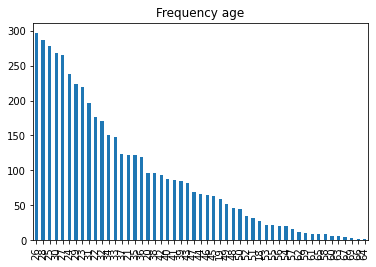

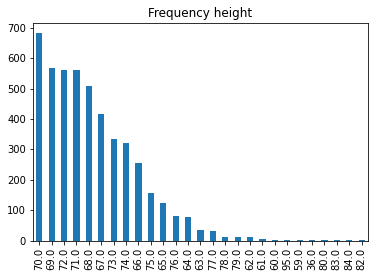

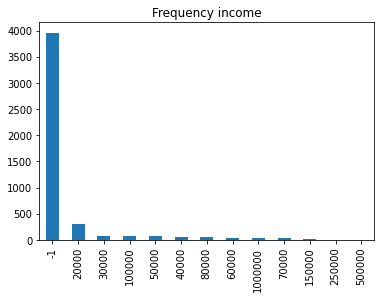

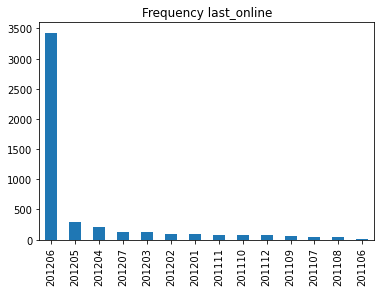

In [71]:
df[["year","month", "deshechar"]] = df["last_online"].str.split("-",expand=True, n=2)
df[["last_online"]] = df["year"] + df["month"] 
plot_frequency(df, ["age", "height", "income", "last_online"])
df.drop(columns = ["deshechar","income", "year", "month"], inplace=True)

anterior_ultimo_mes = df[df["last_online"]< "201206"].index
df.drop(anterior_ultimo_mes,inplace = True)
df.drop(columns = ["last_online"], inplace=True)

df['height'].fillna(df['height'].mode()[0], inplace=True)


In [72]:
print("Dimension actual:", df.shape)

Dimension actual: (3561, 27)


### Categoricas

**A borrar** 

- body_type
- sign
- ethnicity
- education
- essay: Las preprocesaremos en otro notebook guardando el indice

Nos parecen que pueden crear sesgos en nuestro algoritmo o que no son lo suficientemente relevantes.

In [73]:
df.drop(columns = ["body_type","ethnicity", "education", "sign"], inplace=True)
for i in range(0,10):
    df.drop(columns = "essay"+str(i), inplace = True)   
    
print("Dimension actual:", df.shape)


Dimension actual: (3561, 13)



**Categoricas más relevante**
- status: Estado de la relación (Available/Single- 0, Seeing someone-1, Married-2 o Unknown-nan)
- location: lugar de residencia (A coordenadas - latitud, longitud)
- speaks: idiomas (Una columna por cada idiomas y sus puntuaciones) 
  - Lisp o c++ nos parecio interesante dejarlo por aficciones ([1,0.5,0.25, 0])
  - Tambien tenemos en cuenta si le gusta aprender idiomas (number_of_languages)
 

In [74]:
print("Status:", df.status.unique())

Status: ['single' 'seeing someone' 'available' 'married']


In [75]:
## STATUS
def is_avaliable(x):
    if x in ["single", "available"]:
        return 0 
    elif x in ['seeing someone']:
        return 1
    elif x in ["married"]:
        return 2
    elif x in ["unknown"]:
        return np.nan
    else:
        return status[x]
    
df["status"] = df.status.apply(lambda x: is_avaliable(x))
print("Status:", df.status.isnull().sum())
df.drop(df[df.status.isnull()].index, inplace=True)  
print("Status:", df.status.unique())

Status: 0
Status: [0 1 2]


In [ ]:
## LOCATION

#def preprocess_location(dataset, column):
#    for word in ["south", "north", "west"]:
#        dataset[column] = dataset[column].apply(lambda x: str(x).replace(word,""))
#    return dataset[column]

def address_to_coordinates(address):
    location = geolocator.geocode(address)
    return location.latitude, location.longitude
    
df["location"]= df["location"].str.strip()

addresses = df["location"].unique()
latitude, longitude = [],[]

for address in addresses:
    la, lo = address_to_coordinates(address)
    latitude.append(la)
    longitude.append(lo)

    
locations = pd.DataFrame({"location":addresses, "longitude":longitude, "latitude":latitude})
df = df.merge(locations, on = "location")
df.drop(columns= "location", inplace=True)

locations

In [ ]:
## SPEAKS
df.drop(df[df.speaks.isnull()].index, inplace=True)  

if ((len(df)) == (df['speaks'].str.contains("english").sum())):
    print("Todos hablan ingles en mayor o menor medida")

    


In [ ]:
def parentesis(x):
    start = x.find('(') 
    end = x.find(')', start)
    if (start > 0 and end > start):
        level = x[start+1:end]
        language = x.replace(level, "")
    else:
        language = x
        level = "okay"
        
    return level, language.replace("()", "").strip()

df["languages"] = df.speaks.str.split(", ")
df["number_of_languages"] = df["languages"].apply(lambda x: len(x))
df["languages"] = df["languages"].apply(lambda x: [lang.strip() for lang in x]) 
df["languages"] = df["languages"].apply(lambda x: [parentesis(lang) for lang in x] )

unique_languages = set()
levels = set()

for element in df["languages"]:
    for language in element:
        levels.add(language[0])
        if (len(language) > 1):
            unique_languages.add(language[1])

 



In [ ]:
levels = {k:v for k,v in zip(levels, [1,0.5,0.25])}
df["languages"] = df["languages"].apply(lambda x: [ (levels[lang[0]], lang[1]) for lang in x  if (not (lang[0] in "c++") or ( x in "lisp"))])

"""def get_item(lang, l):
    for item in l:
        if item[1] in lang:
            return item[0]
    return 0    
    
for lang in unique_languages:
    df[lang] = df["languages"].apply(lambda x: get_item(lang,x))"""
df.drop(columns= ["languages","speaks"], inplace=True)    


In [ ]:
print("Dimension actual:", df.shape)

**Categoricas menos relevantes**

- smokes: ¿fumas?  (0 No - 1 Si)    
- drugs: ¿Consumidore de drogas? (0 No - 1 Si) 
- drinks: ¿bebedor? (0 No - 1 Socialmente, Raramente - 2 Si)

In [ ]:
### Drinks, drugs
print(df.smokes.unique())
print(df.drinks.unique())
print(df.drugs.unique())

def drinks(x):
    if x in ["often",'desperately', 'very often']:
        return 2
    elif x in ['socially', 'rarely']:
        return 1
    elif x in ['not at all']:
        return 0
    else:
        return x

def drugs(x):
    if x in ["sometimes", 'often']:
        return 1
    elif x in ['never']:
        return 0
    else:
        return x

def smokes(x):
    if x in ["no"]:
        return 0
    elif x in ['sometimes', 'when drinking', 'trying to quit', 'yes']:
        return 1
    else:
        return x

df["drinks"] = df["drinks"].apply(lambda x: drinks(x))
df["drugs"] = df["drugs"].apply(lambda x: drugs(x))
df["smokes"] = df["smokes"].apply(lambda x: smokes(x))


df['drinks'].fillna(df['drinks'].mode()[0], inplace=True)
df['drugs'].fillna(df['drugs'].mode()[0], inplace=True)
df['smokes'].fillna(df['smokes'].mode()[0], inplace=True)

print(df.drinks.unique())
print(df.drugs.unique())
print(df.smokes.unique())

- offspring: preferencia con respecto a los hijos (hijos no 0 - si 1, querer_hijos no 0 - si 1)
- job: empleo/industria (Cambiar unemployed y rather not say to unknown)
   - {'other', 'student', 'artistico', 'retired', ('unemployed',  'rather not say') -> nan }
      - art: 'entertainment / media',  'artistic / musical / writer'
      - tech: 'computer / hardware / software', 'science / tech / engineering'
      - health: 'medicine / health'
      - social:  'banking / financial / real estate', 'law / legal services',  'sales / marketing / biz dev', 'clerical / administrative', 'executive / management', 'political / government', 'education / academia', 'hospitality / travel', 'military'
      - industrial: 'construction / craftsmanship', 'transportation'
- diet: dieta seguida por el usuario (solo tener en cuenta estrictos {vegan, vegetarian, other, halah, kosher})
- pets: preferencia con respecto a las mascotas (cat no 0 si 1, dog  no 0 si 1)
- religion: preferencias religiosas (igual a languages)


In [ ]:
### OffSpring
def hijos(x):
    if "has" in str(x):
        return 1
    elif "doesn't have" in str(x):
        return 0
    else:
        "unknown"   

def querer_hijos(x):
    if  "doesn't want" in str(x):
        return 0 
    elif "want" in str(x):
        return 1
    else:
        return np.nan  
    
df["hijos"] = df.offspring.apply(lambda x: hijos(x))
df["quiere_hijos"] = df.offspring.apply(lambda x: querer_hijos(x))
df.drop(columns = "offspring", inplace = True)

print(df.hijos.unique())
print(df.quiere_hijos.unique())

## Respuesta de si o no
df['hijos'].fillna(df['hijos'].mode()[0], inplace=True)
df['quiere_hijos'].fillna(df['quiere_hijos'].mode()[0], inplace=True)

In [ ]:
## DIET 
def diet(x):
    if pd.isnull(x):
        return "anything"
    if ("other" in x) or ("anything" in x) or ("halah" in x) or ("kosher" in x):
        return "anything"
    
    x = x.replace("mostly ","")
    x = x.replace("strictly ","")
    return x

df.diet = df.diet.apply(lambda x: diet(x))

df['diet'].fillna(df['diet'].mode()[0], inplace=True)

In [ ]:
## PET (Cats-0,1-Dogs-0,1)
def cats(x):
    if pd.isnull(x):
        return x
    cat = ["has cat","likes cats"]
    for string in cat:
        if string in x:
            return 1
        elif "dislikes cats":
            return 0
    return np.nan

def dogs(x):
    if pd.isnull(x):
        return x
    dog = ["has dogs","likes dogs"]
    for string in dog:
        if string in x:
            return 1
        elif "dislikes dogs" in x:
            return 0
    return np.nan
        

print(df.pets.unique())

df["cat"] = df.pets.apply(lambda x: cats(x))
df["dog"] = df.pets.apply(lambda x: dogs(x))
df.drop(columns = "pets", inplace = True)

print(df.dog.unique())
print(df.cat.unique())

df['cat'].fillna(df['cat'].mode()[0], inplace=True)
df['dog'].fillna(df['dog'].mode()[0], inplace=True)

In [ ]:
## JOB 
social = ['banking / financial / real estate', 'law / legal services',  'sales / marketing / biz dev', 'clerical / administrative']
social.append(['executive / management', 'political / government', 'education / academia', 'hospitality / travel','military'])

def job(x):
    if x in ['retired','student']:
        return x
    elif x in ['entertainment / media',  'artistic / musical / writer']:
        return "art"
    elif x in ['computer / hardware / software', 'science / tech / engineering']:
        return "tech"
    elif x in ['medicine / health']:
        return "health"
    elif x in social:
        return "social"
    elif x in ['construction / craftsmanship', 'transportation']:
        return "industry"
    else:
        return np.nan

df.job = df.job.apply(lambda x: job(x))

df['job'].fillna(df['religion'].mode()[0], inplace=True)

In [ ]:
## RELIGION
religion_dict = {
    "and laughing about it": 0.1,
    "but not too serious about it": 0.25,
    "and somewhat serious about it": 0.5,
    "and very serious about it": 1
}
def religion(x):
    if pd.isnull(x):
        return x
    a = x.split(" ", maxsplit=1)
    if (len(a) < 2):
        return (a[0], 0.5)        
    puntuation = 0
    for phrase in religion_dict:
        if a[1] in phrase:
            return a[0], religion_dict[phrase]
    
    return a[0], 0

religions = set([i.split(" ", maxsplit=1)[0]for i in df.religion.unique() if pd.notnull(i)])

df.religion = df.religion.apply(lambda x: religion(x))

for rel in religions:
    df[rel] = df.religion.apply(lambda x: x[1] if (pd.notnull(x) and (x[0] in rel)) else 0)
    
df.drop(columns = "religion", inplace = True)    

## Categoricas -> One Hot Encoder

In [ ]:
print(df.select_dtypes(include=['object']).columns)

if "sex" in df.columns.to_list():
    df.drop(columns="sex", inplace=True)   

In [ ]:
df = df.join(pd.get_dummies(df.job, prefix='Job'))
df.drop(columns = ["job"], inplace=True)
df = df.join(pd.get_dummies(df.diet, prefix='Diet'))
df.drop(columns = ["diet"], inplace=True)

print(df.select_dtypes(include=['object']).columns)    

## Estandarizacion

In [ ]:
a = zip(list(df.isnull().sum()), list(df.isnull().sum().index))
for n, i in a:
    if n > 0:
        print(n, i)

In [ ]:
for column in df.columns:
    df[column] = scale(df[column])

In [ ]:
df.shape

## Save

In [ ]:
print("Longitud del dataset: ", df.shape)
save_path = path_actual + "/dataset/"+ DATASETS[N_DATASET][:len(DATASETS[N_DATASET])-4]+"_preprocesado.csv"

save_path

In [ ]:
df.to_csv(save_path)